### setting

In [ ]:
!pip install transformers
!git clone https://github.com/seoyeon9646/MLM-data-augmentation

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 26.3 MB/s 
     |████████████████████████████████| 182 kB 68.3 MB/s 
     |████████████████████████████████| 7.6 MB 60.0 MB/s 
Cloning into 'MLM-data-augmentation'...
remote: Enumerating objects: 46, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 46 (delta 23), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (46/46), done.


In [ ]:
import os

os.rename('MLM-data-augmentation', 'mlm')

In [ ]:
import torch
import random
import copy
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torch import nn

from transformers import AutoModel, AutoTokenizer, AutoModelForMaskedLM, AdamW

from tqdm.notebook import tqdm
from typing import Union

from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from mlm.utils import mask_tokens

warnings.filterwarnings(action='ignore')
plt.rc('font', family='NanumGothic')
plt.rc('font', family='AppleGothic')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
epochs = 15
batch_size = 10
learning_rate = 1e-5
seed = 0
data_path = '/content/drive/MyDrive/dacon/dataset/'

In [ ]:
# GPU 사용
device = 'cuda' if torch.cuda.is_available() else 'cpu'
max_grad_norm = 1

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(seed) # Seed 고정

### 데이터 load

In [ ]:
data = pd.read_csv(data_path+'train_aug.csv')
# data.drop(columns=['ID'], inplace=True)
data

,문장,유형,극성,시제,확실성,label
0,0.75%포인트 금리 인상은 1994년 이후 28년 만에 처음이다.,사실형,긍정,현재,확실,사실형-긍정-현재-확실
1,이어 ＂앞으로 전문가들과 함께 4주 단위로 상황을 재평가할 예정＂이라며 ＂그 이전이...,사실형,긍정,과거,확실,사실형-긍정-과거-확실
2,정부가 고유가 대응을 위해 7월부터 연말까지 유류세 인하 폭을 30%에서 37%까지...,사실형,긍정,미래,확실,사실형-긍정-미래-확실
3,"서울시는 올해 3월 즉시 견인 유예시간 60분을 제공하겠다고 밝혔지만, 하루 만에 ...",사실형,긍정,과거,확실,사실형-긍정-과거-확실
4,익사한 자는 사다리에 태워 거꾸로 놓고 소금으로 코를 막아 가득 채운다.,사실형,긍정,현재,확실,사실형-긍정-현재-확실
...,...,...,...,...,...,...
23824,긴 나물과 안긴 나물과 비슷 할 수 있다.,대화형,부정,현재,불확실,대화형-부정-현재-불확실
23825,아내를 사랑할 일이가 없는 걸 어떻게 설명 할 수가 있겠습니까.,대화형,부정,과거,불확실,대화형-부정-과거-불확실
23826,단기 하락은 있을 수 있지만 올해 11월부터 장기 하락 가능성은 크지 않음.,대화형,부정,현재,불확실,대화형-부정-현재-불확실
23827,""" 청년 일자리 "" 이란 영화가 만드는 것에 지치지 않았나요??",대화형,부정,현재,불확실,대화형-부정-현재-불확실


Text(0.5, 1.0, 'Distribution of certainty')

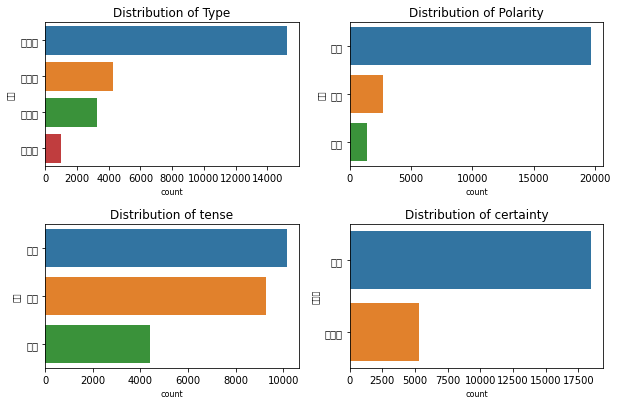

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.4)

g = sns.countplot(y="유형", data=data,order = data['유형'].value_counts().index , ax = axes[0][0])
axes[0][0].set_xlabel(g.get_xlabel(), fontsize=8)
axes[0][0].set_ylabel(g.get_ylabel(), fontsize=8) 
axes[0][0].set_title('Distribution of Type')

g = sns.countplot(y="극성", data=data,order = data['극성'].value_counts().index , ax = axes[0][1])
axes[0][1].set_xlabel(g.get_xlabel(), fontsize=8)
axes[0][1].set_ylabel(g.get_ylabel(), fontsize=8) 
axes[0][1].set_title('Distribution of Polarity')

g = sns.countplot(y="시제", data=data,order = data['시제'].value_counts().index , ax = axes[1][0])
axes[1][0].set_xlabel(g.get_xlabel(), fontsize=8)
axes[1][0].set_ylabel(g.get_ylabel(), fontsize=8) 
axes[1][0].set_title('Distribution of tense')

g = sns.countplot(y="확실성", data=data,order = data['확실성'].value_counts().index , ax = axes[1][1])
axes[1][1].set_xlabel(g.get_xlabel(), fontsize=8)
axes[1][1].set_ylabel(g.get_ylabel(), fontsize=8) 
axes[1][1].set_title('Distribution of certainty')

In [ ]:
print(data['유형'].value_counts())
print(data['극성'].value_counts())
print(data['시제'].value_counts())
print(data['확실성'].value_counts())

사실형    15223
추론형     4292
대화형     3290
예측형     1024
Name: 유형, dtype: int64
긍정    19677
미정     2702
부정     1450
Name: 극성, dtype: int64
현재    10149
과거     9280
미래     4400
Name: 시제, dtype: int64
확실     18489
불확실     5340
Name: 확실성, dtype: int64


### Stratified 5-Fold

In [ ]:
# Cross validation, StratifiedKfold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
folds=[]

# Seperate train set and validation set in each folds
for train_idx, valid_idx in skf.split(data, data['극성']):
    folds.append((train_idx, valid_idx))

In [ ]:
data.iloc[folds[0][0]].reset_index(drop=True)

,문장,유형,극성,시제,확실성,label
0,0.75%포인트 금리 인상은 1994년 이후 28년 만에 처음이다.,사실형,긍정,현재,확실,사실형-긍정-현재-확실
1,이어 ＂앞으로 전문가들과 함께 4주 단위로 상황을 재평가할 예정＂이라며 ＂그 이전이...,사실형,긍정,과거,확실,사실형-긍정-과거-확실
2,정부가 고유가 대응을 위해 7월부터 연말까지 유류세 인하 폭을 30%에서 37%까지...,사실형,긍정,미래,확실,사실형-긍정-미래-확실
3,"서울시는 올해 3월 즉시 견인 유예시간 60분을 제공하겠다고 밝혔지만, 하루 만에 ...",사실형,긍정,과거,확실,사실형-긍정-과거-확실
4,익사한 자는 사다리에 태워 거꾸로 놓고 소금으로 코를 막아 가득 채운다.,사실형,긍정,현재,확실,사실형-긍정-현재-확실
...,...,...,...,...,...,...
19058,긴 나물과 안긴 나물과 비슷 할 수 있다.,대화형,부정,현재,불확실,대화형-부정-현재-불확실
19059,아내를 사랑할 일이가 없는 걸 어떻게 설명 할 수가 있겠습니까.,대화형,부정,과거,불확실,대화형-부정-과거-불확실
19060,단기 하락은 있을 수 있지만 올해 11월부터 장기 하락 가능성은 크지 않음.,대화형,부정,현재,불확실,대화형-부정-현재-불확실
19061,""" 청년 일자리 "" 이란 영화가 만드는 것에 지치지 않았나요??",대화형,부정,현재,불확실,대화형-부정-현재-불확실


### Data Augmentation by MLM

In [ ]:
# def tokenize(tokenizer:AutoTokenizer, sent:str):
#     encoded_dict = tokenizer(
#         sent,
#         add_special_tokens = True,
#         return_attention_mask = True,
#         return_tensors = "pt"
#     )
#     input_id, attention_mask = encoded_dict.input_ids, encoded_dict.attention_mask

#     return input_id, attention_mask

# def is_same_token_type(org_token:str, candidate:str) -> bool:
#     '''
#     후보 필터링 조건을 만족하는지 확인
#     - 후보와 원 토큰의 타입을 문장부호와 일반 토큰으로 나누어 같은 타입에 속하는지 확인
#     '''
#     res = False
#     if org_token[0]=="#" and org_token[2:].isalpha()==candidate.isalpha():
#         res = True
#     elif candidate[0]=="#" and org_token.isalpha()==candidate[2:].isalpha():
#         res = True
#     elif candidate[0]=="#" and org_token[0]=="#" and org_token[2:].isalpha()==candidate[2:].isalpha():
#         res = True
#     elif org_token.isalpha()==candidate.isalpha() and (candidate[0]!="#" and org_token[0]!="#"):
#         res = True

#     return res

# def candidate_filtering(tokenizer:AutoTokenizer,
#                         input_ids:list,
#                         idx:int,
#                         org:int,
#                         candidates:Union[list, torch.Tensor]) -> int:
#     '''
#     후보 필터링 조건에 만족하는 최적의 후보 선택
#     1. 원래 토큰과 후보 토큰이 같은 타입(is_same_token_type 참고)
#     2. 현 위치 앞 혹은 뒤에 동일한 토큰이 있지 않음
#     '''

#     org_token = tokenizer.convert_ids_to_tokens([org])[0]
#     candidate_tokens = tokenizer.convert_ids_to_tokens(candidates.cpu().tolist())

#     for rank, token in enumerate(candidate_tokens):
#         if org_token!=token and is_same_token_type(org_token, token):
#             if input_ids[idx-1]==candidates[rank] or input_ids[idx+1]==candidate_tokens[rank]:
#                 continue
#             return candidates[rank]

#     return org

# def augment_one_sent(model:AutoModelForMaskedLM,
#                     tokenizer:AutoTokenizer,
#                     sent:str,
#                     dev:Union[str, torch.device]) -> str:

#     k = 5
#     threshold = 0.95
#     mlm_prob = 0.15

#     model.eval()

#     input_id, attention_mask  = tokenize(tokenizer, sent)
#     org_ids = copy.deepcopy(input_id[0])
    
#     masked_input_id, _ = mask_tokens(tokenizer, input_id, mlm_prob, do_rep_random=False)
#     while masked_input_id.cpu().tolist()[0].count(tokenizer.mask_token_id) < 1:
#         masked_input_id, _ = mask_tokens(tokenizer, input_id, mlm_prob, do_rep_random=False)
    
#     with torch.no_grad():
#         masked_input_id, attention_mask = masked_input_id.to(dev), attention_mask.to(dev)
#         output = model(masked_input_id, attention_mask = attention_mask)
#         logits = output["logits"][0]

#     copied = copy.deepcopy(masked_input_id.cpu().tolist()[0])
#     for i in range(len(copied)):
#         if copied[i] == tokenizer.mask_token_id:
#             org_token = org_ids[i]
#             prob = logits[i].softmax(dim=0)
#             probability, candidates = prob.topk(k)
#             if probability[0]<threshold:
#                 res = candidate_filtering(tokenizer, copied, i, org_token, candidates)
#             else:
#                 res = candidates[0]
#             copied[i] = res

#     copied = tokenizer.decode(copied, skip_special_tokens=True)

#     return copied

In [ ]:
# dev = "cuda:{}".format(0)
# # dev = "cpu"
        
# model = AutoModelForMaskedLM.from_pretrained("seoyeon96/KcELECTRA-MLM")
# tokenizer = AutoTokenizer.from_pretrained("seoyeon96/KcELECTRA-MLM")

# model.to(dev)

In [ ]:
# def augmentation(orig_data, aug_data, k):
#     list = []

#     for i in aug_data['문장']:
#         list.append(i)

#     for i in range(0, k):
#         aug_list = []

#         for j in list:
#             aug = augment_one_sent(model, tokenizer, j, dev)
#             aug_list.append(aug)

#         new_text = pd.DataFrame(aug_list, columns=['aug'])
#         new_train = pd.concat([aug_data, new_text], axis=1)

#         new_train.drop(columns=['문장'], inplace=True)
#         new_train.rename(columns={'aug':'문장'}, inplace=True)

#         new_c = new_train.columns[-1:].to_list() + new_train.columns[:-1].to_list()
#         new_train = new_train[new_c]

#         if i == 0:
#             augmented = pd.concat([aug_data, new_train])
#         else:
#             augmented = pd.concat([augmented, new_train])
#         augmented = augmented.reset_index(drop=True)

#     for i in range(0, len(augmented)):
#         augmented.at[i, '문장'] = augmented['문장'][i].replace('.?','?')

#     result = pd.concat([orig_data, augmented])
#     result = result.reset_index(drop = True)

#     return result

In [ ]:
for idx in range(0, 5):
    train = data.iloc[folds[idx][0]].reset_index(drop=True)
    val = data.iloc[folds[idx][1]].reset_index(drop=True)

    # a = train[(train['유형']!='사실형') & (train['극성']=='부정') & (train['확실성']=='불확실') & (train['시제']=='미래')]
    # b = train[(train['유형']!='사실형') & (train['극성']=='미정') & (train['확실성']=='불확실') & (train['시제']=='미래')]
    # df = pd.concat([a,b])
    # df = df.reset_index(drop=True)
    # train = augmentation(train, df, 4)

    # a = train[(train['유형']!='사실형') & (train['극성']=='부정') & (train['확실성']=='불확실')]
    # b = train[(train['유형']!='사실형') & (train['극성']=='미정') & (train['확실성']=='불확실')]
    # df = pd.concat([a,b])
    # df = df.reset_index(drop=True)
    # train = augmentation(train, df, 4)

    # a = train[(train['유형']=='예측형')]
    # b = train[(train['유형']=='대화형')]
    # df = pd.concat([a,b])
    # df = df.reset_index(drop=True)
    # result = augmentation(train, df, 1)

    train.to_csv(f'{data_path}/train_aug_{idx}.csv', index=False, compression=None)
    val.to_csv(f'{data_path}/val_{idx}.csv', index=False, compression=None)

In [ ]:
train_0 = pd.read_csv(f'{data_path}/train_aug_0.csv')
train_1 = pd.read_csv(f'{data_path}/train_aug_1.csv')
train_2 = pd.read_csv(f'{data_path}/train_aug_2.csv')
train_3 = pd.read_csv(f'{data_path}/train_aug_3.csv')
train_4 = pd.read_csv(f'{data_path}/train_aug_4.csv')

val_0 = pd.read_csv(f'{data_path}/val_0.csv')
val_1 = pd.read_csv(f'{data_path}/val_1.csv')
val_2 = pd.read_csv(f'{data_path}/val_2.csv')
val_3 = pd.read_csv(f'{data_path}/val_3.csv')
val_4 = pd.read_csv(f'{data_path}/val_4.csv')

Text(0.5, 1.0, 'Distribution of certainty')

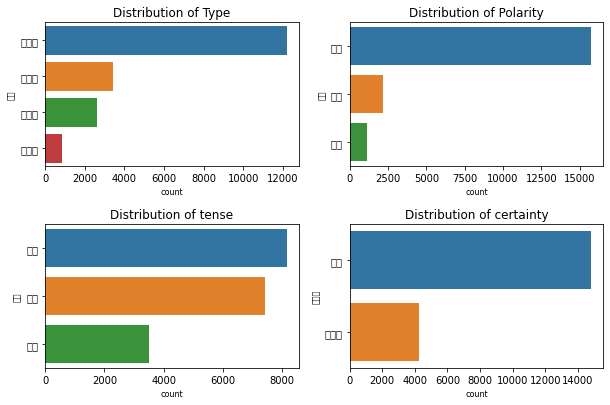

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.4)

g = sns.countplot(y="유형", data=train_0,order = train_0['유형'].value_counts().index , ax = axes[0][0])
axes[0][0].set_xlabel(g.get_xlabel(), fontsize=8)
axes[0][0].set_ylabel(g.get_ylabel(), fontsize=8) 
axes[0][0].set_title('Distribution of Type')

g = sns.countplot(y="극성", data=train_0,order = train_0['극성'].value_counts().index , ax = axes[0][1])
axes[0][1].set_xlabel(g.get_xlabel(), fontsize=8)
axes[0][1].set_ylabel(g.get_ylabel(), fontsize=8) 
axes[0][1].set_title('Distribution of Polarity')

g = sns.countplot(y="시제", data=train_0,order = train_0['시제'].value_counts().index , ax = axes[1][0])
axes[1][0].set_xlabel(g.get_xlabel(), fontsize=8)
axes[1][0].set_ylabel(g.get_ylabel(), fontsize=8) 
axes[1][0].set_title('Distribution of tense')

g = sns.countplot(y="확실성", data=train_0,order = train_0['확실성'].value_counts().index , ax = axes[1][1])
axes[1][1].set_xlabel(g.get_xlabel(), fontsize=8)
axes[1][1].set_ylabel(g.get_ylabel(), fontsize=8) 
axes[1][1].set_title('Distribution of certainty')

In [ ]:
print(train_0['유형'].value_counts())
print(train_0['극성'].value_counts())
print(train_0['시제'].value_counts())
print(train_0['확실성'].value_counts())

사실형    12191
추론형     3434
대화형     2611
예측형      827
Name: 유형, dtype: int64
긍정    15741
미정     2162
부정     1160
Name: 극성, dtype: int64
현재    8157
과거    7409
미래    3497
Name: 시제, dtype: int64
확실     14805
불확실     4258
Name: 확실성, dtype: int64


### Dataset 만들기

In [ ]:
class Dataset(Dataset):
  
  def __init__(self, dataset, train):
    self.dataset = dataset
    self.tokenizer = AutoTokenizer.from_pretrained("jinmang2/kpfbert")
    self.sentences = self.dataset["문장"].tolist()
    self.train = train
    if self.train:
      self.type_labels = [np.int32(i) for i in self.dataset["유형"]]
      self.polarity_labels = [np.int32(i) for i in self.dataset["극성"]]
      self.tense_labels = [np.int32(i) for i in self.dataset["시제"]]
      self.certainty_labels = [np.int32(i) for i in self.dataset["확실성"]]

  def __len__(self):
    return len(self.dataset)
  
  def __getitem__(self, idx):
    
      inputs = self.tokenizer(
          self.sentences[idx], 
          return_tensors='pt',
          truncation=True,
          max_length=256,
          pad_to_max_length=True,
          add_special_tokens=True
          )
      input_ids = inputs['input_ids'][0]
      attention_mask = inputs['attention_mask'][0]
      if self.train:
        return input_ids, attention_mask, self.type_labels[idx], self.polarity_labels[idx], self.tense_labels[idx], self.certainty_labels[idx]
      return input_ids, attention_mask

In [ ]:
label_dict = {"유형":{"사실형":0, "추론형":1, "대화형":2, "예측형":3}, "극성":{"긍정":0, "부정":1, "미정":2}, "시제":{"과거":0, "현재":1, "미래":2}, "확실성":{"확실":0, "불확실":1}}

for idx in range(0, 5):
  for label in label_dict:
    for i in range(len(globals()[f'train_{idx}'])):
      globals()[f'train_{idx}'][label].iloc[i] = label_dict[label][globals()[f'train_{idx}'][label].iloc[i]]

In [ ]:
label_dict = {"유형":{"사실형":0, "추론형":1, "대화형":2, "예측형":3}, "극성":{"긍정":0, "부정":1, "미정":2}, "시제":{"과거":0, "현재":1, "미래":2}, "확실성":{"확실":0, "불확실":1}}

for idx in range(0, 5):
  for label in label_dict:
    for i in range(len(globals()[f'val_{idx}'])):
      globals()[f'val_{idx}'][label].iloc[i] = label_dict[label][globals()[f'val_{idx}'][label].iloc[i]]

In [ ]:
for idx in range(0, 5):
    globals()[f'train_dataset_{idx}'] = Dataset(globals()[f'train_{idx}'], True)
    globals()[f'val_dataset_{idx}'] = Dataset(globals()[f'val_{idx}'], True)

Downloading:   0%|          | 0.00/335 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/276k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

### Create Model

In [ ]:
for idx in range(0,5):
    globals()[f'model_{idx}'] = AutoModel.from_pretrained("jinmang2/kpfbert")

Some weights of BertModel were not initialized from the model checkpoint at jinmang2/kpfbert and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertModel were not initialized from the model checkpoint at jinmang2/kpfbert and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertModel were not initialized from the model checkpoint at jinmang2/kpfbert and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertModel were not initialized from the model checkpoint at jinmang2/kpfbert and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You sho

In [ ]:
# model.load_state_dict(torch.load("model.pt"))

In [ ]:
model_0.to(device)
model_1.to(device)
model_2.to(device)
model_3.to(device)
model_4.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(36440, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [ ]:
class Classifier(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

        self.fc1 = nn.Linear(768 , 768)
        self.do = nn.Dropout(p=0.1, inplace=False)
        self.type_classifier = nn.Linear(768 , 4)
        self.polarity_classifier = nn.Linear(768 , 3)
        self.tense_classifier = nn.Linear(768 , 3)
        self.certainty_classifier = nn.Linear(768 , 2)
  
    def forward(self, input_ids, attention_mask):
        # input_ids : token's id / attention_mask : make a model to focus on which token
        model_out = self.model(input_ids= input_ids, attention_mask = attention_mask)[0][:,0]

        x = self.fc1(model_out)
        x = self.do(x)

        type_output = self.type_classifier(x)
        polarity_output = self.polarity_classifier(x)
        tense_output = self.tense_classifier(x)
        certainty_output = self.certainty_classifier(x)

        return type_output, polarity_output, tense_output, certainty_output

In [ ]:
for idx in range(0,5):
    globals()[f'model_{idx}'] = Classifier(globals()[f'model_{idx}'])

In [ ]:
model_0.to(device)
model_1.to(device)
model_2.to(device)
model_3.to(device)
model_4.to(device)

Classifier(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(36440, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)


### Learn

In [ ]:
for idx in range(0, 5):
    globals()[f'optimizer_{idx}'] = AdamW(globals()[f'model_{idx}'].parameters(), lr=learning_rate, weight_decay=1e-4)
    globals()[f'train_loader_{idx}'] = DataLoader(globals()[f'train_dataset_{idx}'], batch_size=batch_size, shuffle=True)
    globals()[f'val_loader_{idx}'] = DataLoader(globals()[f'val_dataset_{idx}'], batch_size=batch_size, shuffle=True)

In [ ]:
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=3, verbose=False, delta=0, path='/content/drive/MyDrive/dacon/saved_models/best_model.pth'):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 3
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [ ]:
def validation(model, val_loader, criterion, device):
    model.eval()
    val_loss = []
    
    type_preds, polarity_preds, tense_preds, certainty_preds = [], [], [], []
    type_labels, polarity_labels, tense_labels, certainty_labels = [], [], [], []
    
    
    with torch.no_grad():
      for input_ids_batch, attention_masks_batch, type_label, polarity_label, tense_label, certainty_label in tqdm(val_loader):
        type_label = type_label.long().to(device)
        polarity_label = polarity_label.long().to(device)
        tense_label = tense_label.long().to(device)
        certainty_label = certainty_label.long().to(device)
        type_logit, polarity_logit, tense_logit, certainty_logit = model(input_ids_batch.to(device), attention_masks_batch.to(device))
        loss = 0.25 * criterion['type'](type_logit, type_label) + \
                    0.25 * criterion['polarity'](polarity_logit, polarity_label) + \
                    0.25 * criterion['tense'](tense_logit, tense_label) + \
                    0.25 * criterion['certainty'](certainty_logit, certainty_label)
          
        val_loss.append(loss.item())
        
        type_preds += type_logit.argmax(1).detach().cpu().numpy().tolist()
        type_labels += type_label.detach().cpu().numpy().tolist()
        
        polarity_preds += polarity_logit.argmax(1).detach().cpu().numpy().tolist()
        polarity_labels += polarity_label.detach().cpu().numpy().tolist()
        
        tense_preds += tense_logit.argmax(1).detach().cpu().numpy().tolist()
        tense_labels += tense_label.detach().cpu().numpy().tolist()
        
        certainty_preds += certainty_logit.argmax(1).detach().cpu().numpy().tolist()
        certainty_labels += certainty_label.detach().cpu().numpy().tolist()
    type_f1 = f1_score(type_labels, type_preds, average='weighted')
    polarity_f1 = f1_score(polarity_labels, polarity_preds, average='weighted')
    tense_f1 = f1_score(tense_labels, tense_preds, average='weighted')
    certainty_f1 = f1_score(certainty_labels, certainty_preds, average='weighted')
    
    return np.mean(val_loss), type_f1, polarity_f1, tense_f1, certainty_f1

In [ ]:
def train(model, optimizer, train_loader, val_loader, device, path, idx):
  log_df = {"train_losses":[], "val_losses":[], "type_f1s":[], "polarity_f1s":[], "tense_f1s":[], "certainty_f1s":[]}

  criterion = {
      'type' : nn.CrossEntropyLoss().to(device),
      'polarity' : nn.CrossEntropyLoss().to(device),
      'tense' : nn.CrossEntropyLoss().to(device),
      'certainty' : nn.CrossEntropyLoss().to(device)
  }
  
  early_stopping = EarlyStopping(patience=2, verbose=True, path=path)
  
  for e in range(epochs):
    train_loss = []
    for input_ids_batch, attention_masks_batch, type_label, polarity_label, tense_label, certainty_label in tqdm(train_loader):
      model.train()
      optimizer.zero_grad()
      type_label = type_label.long().to(device)
      polarity_label = polarity_label.long().to(device)
      tense_label = tense_label.long().to(device)
      certainty_label = certainty_label.long().to(device)
      type_logit, polarity_logit, tense_logit, certainty_logit = model(input_ids_batch.to(device), attention_masks_batch.to(device))

      loss = 0.25 * criterion['type'](type_logit, type_label) + \
                  0.25 * criterion['polarity'](polarity_logit, polarity_label) + \
                  0.25 * criterion['tense'](tense_logit, tense_label) + \
                  0.25 * criterion['certainty'](certainty_logit, certainty_label)

      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
      optimizer.step()
      train_loss.append(loss.item())

    model.eval()
    val_loss, type_f1, polarity_f1, tense_f1, certainty_f1 = validation(model, val_loader, criterion, device)
    print(f'Epoch : [{e+1}] Train Loss : [{np.mean(train_loss):.5f}] Val Loss : [{val_loss:.5f}] 유형 F1 : [{type_f1:.5f}] 극성 F1 : [{polarity_f1:.5f}] 시제 F1 : [{tense_f1:.5f}] 확실성 F1 : [{certainty_f1:.5f}]')
    
    log_df["val_losses"].append(val_loss)
    log_df["train_losses"].append(np.mean(train_loss))
    log_df["type_f1s"].append(type_f1)
    log_df["polarity_f1s"].append(polarity_f1)
    log_df["tense_f1s"].append(tense_f1)
    log_df["certainty_f1s"].append(certainty_f1)

    early_stopping(val_loss, model)
    if early_stopping.early_stop:
      print("Early stopping")
      break
    
    pd.DataFrame(log_df).to_csv(f'/content/drive/MyDrive/dacon/log/log_{idx}.csv')
    # torch.save(model.state_dict(), f"/content/drive/MyDrive/dacon/saved_models/model_state_dict{str(e+1).zfill(4)}.pth")

In [ ]:
for idx in range(0,5):
    globals()[f'model{idx}'] = train(globals()[f'model_{idx}'], globals()[f'optimizer_{idx}'], globals()[f'train_loader_{idx}'], globals()[f'val_loader_{idx}'], device, f'/content/drive/MyDrive/dacon/saved_models/best_model_{idx}.pth', idx)

  0%|          | 0/1907 [00:00<?, ?it/s]

  0%|          | 0/477 [00:00<?, ?it/s]

Epoch : [1] Train Loss : [0.34663] Val Loss : [0.27211] 유형 F1 : [0.84156] 극성 F1 : [0.95212] 시제 F1 : [0.89591] 확실성 F1 : [0.90500]
Validation loss decreased (inf --> 0.272107).  Saving model ...


  0%|          | 0/1907 [00:00<?, ?it/s]

  0%|          | 0/477 [00:00<?, ?it/s]

Epoch : [2] Train Loss : [0.23500] Val Loss : [0.24524] 유형 F1 : [0.85564] 극성 F1 : [0.96591] 시제 F1 : [0.90009] 확실성 F1 : [0.91587]
Validation loss decreased (0.272107 --> 0.245241).  Saving model ...


  0%|          | 0/1907 [00:00<?, ?it/s]

  0%|          | 0/477 [00:00<?, ?it/s]

Epoch : [3] Train Loss : [0.17595] Val Loss : [0.24182] 유형 F1 : [0.86860] 극성 F1 : [0.97257] 시제 F1 : [0.90281] 확실성 F1 : [0.92545]
Validation loss decreased (0.245241 --> 0.241822).  Saving model ...


  0%|          | 0/1907 [00:00<?, ?it/s]

  0%|          | 0/477 [00:00<?, ?it/s]

Epoch : [4] Train Loss : [0.12010] Val Loss : [0.25962] 유형 F1 : [0.87828] 극성 F1 : [0.97364] 시제 F1 : [0.90875] 확실성 F1 : [0.93161]
EarlyStopping counter: 1 out of 2


  0%|          | 0/1907 [00:00<?, ?it/s]

  0%|          | 0/477 [00:00<?, ?it/s]

Epoch : [5] Train Loss : [0.07888] Val Loss : [0.30701] 유형 F1 : [0.88735] 극성 F1 : [0.97077] 시제 F1 : [0.91915] 확실성 F1 : [0.93752]
EarlyStopping counter: 2 out of 2
Early stopping


  0%|          | 0/1907 [00:00<?, ?it/s]

  0%|          | 0/477 [00:00<?, ?it/s]

Epoch : [1] Train Loss : [0.34789] Val Loss : [0.27286] 유형 F1 : [0.85398] 극성 F1 : [0.95805] 시제 F1 : [0.88979] 확실성 F1 : [0.89860]
Validation loss decreased (inf --> 0.272862).  Saving model ...


  0%|          | 0/1907 [00:00<?, ?it/s]

  0%|          | 0/477 [00:00<?, ?it/s]

Epoch : [2] Train Loss : [0.23381] Val Loss : [0.24927] 유형 F1 : [0.85731] 극성 F1 : [0.96487] 시제 F1 : [0.89723] 확실성 F1 : [0.91061]
Validation loss decreased (0.272862 --> 0.249273).  Saving model ...


  0%|          | 0/1907 [00:00<?, ?it/s]

  0%|          | 0/477 [00:00<?, ?it/s]

Epoch : [3] Train Loss : [0.17488] Val Loss : [0.24415] 유형 F1 : [0.87922] 극성 F1 : [0.96991] 시제 F1 : [0.89612] 확실성 F1 : [0.91914]
Validation loss decreased (0.249273 --> 0.244148).  Saving model ...


  0%|          | 0/1907 [00:00<?, ?it/s]

  0%|          | 0/477 [00:00<?, ?it/s]

Epoch : [4] Train Loss : [0.11811] Val Loss : [0.26741] 유형 F1 : [0.88499] 극성 F1 : [0.96839] 시제 F1 : [0.90503] 확실성 F1 : [0.92461]
EarlyStopping counter: 1 out of 2


  0%|          | 0/1907 [00:00<?, ?it/s]

  0%|          | 0/477 [00:00<?, ?it/s]

Epoch : [5] Train Loss : [0.07538] Val Loss : [0.31926] 유형 F1 : [0.89766] 극성 F1 : [0.97000] 시제 F1 : [0.89962] 확실성 F1 : [0.93386]
EarlyStopping counter: 2 out of 2
Early stopping


### Inference

In [ ]:
testset = pd.read_csv('/content/drive/MyDrive/dacon/dataset/test.csv')

data_test = Dataset(testset, False)
test_dataloader = DataLoader(data_test, batch_size=batch_size)

In [ ]:
len(data_test)

7090

In [ ]:
model4.to(device)

AttributeError: ignored

In [ ]:
def inference(test_dataloader, device):
    for idx in range(0, 5):
      
      pretrained_dict = torch.load(f'/content/drive/MyDrive/dacon/saved_models/best_model_{idx}.pth')
      globals()[f'model_{idx}'].load_state_dict(pretrained_dict)
      globals()[f'infer_model{idx}'] = globals()[f'model_{idx}']

      globals()[f'infer_model{idx}'].to(device)
      globals()[f'infer_model{idx}'].eval()
    
    type_preds, polarity_preds, tense_preds, certainty_preds = [], [], [], []
    
    with torch.no_grad():
      for i in tqdm(test_dataloader):

        type_logit0, polarity_logit0, tense_logit0, certainty_logit0 = infer_model0(i[0].to(device), i[1].to(device))
        type_logit1, polarity_logit1, tense_logit1, certainty_logit1 = infer_model1(i[0].to(device), i[1].to(device))
        type_logit2, polarity_logit2, tense_logit2, certainty_logit2 = infer_model2(i[0].to(device), i[1].to(device))
        type_logit3, polarity_logit3, tense_logit3, certainty_logit3 = infer_model3(i[0].to(device), i[1].to(device))
        type_logit4, polarity_logit4, tense_logit4, certainty_logit4 = infer_model4(i[0].to(device), i[1].to(device))
        
        type_logit = (type_logit0 + type_logit1 + type_logit2 + type_logit3 + type_logit4)/5
        polarity_logit = (polarity_logit0 + polarity_logit1 + polarity_logit2 + polarity_logit3 + polarity_logit4)/5
        tense_logit = (tense_logit0 + tense_logit1 + tense_logit2 + tense_logit3 + tense_logit4)/5
        certainty_logit = (certainty_logit0 + certainty_logit1 + certainty_logit2 + certainty_logit3 + certainty_logit4)/5

        type_preds += type_logit.argmax(1).detach().cpu().numpy().tolist()
        polarity_preds += polarity_logit.argmax(1).detach().cpu().numpy().tolist()
        tense_preds += tense_logit.argmax(1).detach().cpu().numpy().tolist()
        certainty_preds += certainty_logit.argmax(1).detach().cpu().numpy().tolist()

    return type_preds, polarity_preds, tense_preds, certainty_preds

In [ ]:
type_preds, polarity_preds, tense_preds, certainty_preds = inference(test_dataloader, device)

  0%|          | 0/709 [00:00<?, ?it/s]

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
tensor([[ 0.1368, -1.9857,  4.7542, -3.3060],
        [ 5.6123, -0.5271, -2.0486, -2.9970],
        [ 4.0007,  2.1030, -1.7399, -4.4904],
        [ 5.8706,  0.7152, -4.1491, -2.7984],
        [ 3.3641,  4.2249, -3.6547, -3.9609],
        [ 1.7710,  4.5154, -2.7794, -3.4697],
        [ 5.8546, -0.6330, -2.4448, -2.7240],
        [ 5.8549, -1.5570, -1.8240, -2.9459],
        [ 2.6670,  3.8798, -2.7483, -3.7088],
        [ 4.4835,  0.2371, -0.8847, -4.2509]], device='cuda:0')
tensor([[ 5.5901,  0.7173, -3.4706, -3.2272],
        [ 4.9264, -0.9327, -3.7027, -0.6796],
        [-0.6061,  5.4966, -1.3620, -3.6927],
        [ 5.0559, -1.0492, -3.8309, -0.4285],
        [ 6.7934, -0.9669, -2.6839, -2.8734],
        [ 5.5917, -0.1477, -1.9513, -3.6603],
        [ 6.6732, -0.9545, -3.4176, -2.2271],
        [ 1.4495,  2.9466, -1.3874, -3.8282],
        [ 4.3369,  2.8840, -3.1662, -3.8723],
        [ 6.0517,  0.2280, -2.7379, -3.3403]], device='cuda:0')
tensor([

In [ ]:
label_dict = {"유형":["사실형", "추론형", "대화형", "예측형"], "극성":["긍정", "부정", "미정"], "시제":["과거", "현재", "미래"], "확실성":["확실", "불확실"]}

In [ ]:
len(type_preds)

7090

In [ ]:
type_preds = [label_dict["유형"][x] for x in type_preds]
polarity_preds = [label_dict["극성"][x] for x in polarity_preds]
tense_preds = [label_dict["시제"][x] for x in tense_preds]
certainty_preds = [label_dict["확실성"][x] for x in certainty_preds]

In [ ]:
predictions = []
for type_pred, polarity_pred, tense_pred, certainty_pred in zip(type_preds, polarity_preds, tense_preds, certainty_preds):
    predictions.append(type_pred+'-'+polarity_pred+'-'+tense_pred+'-'+certainty_pred)

In [ ]:
len(predictions)

7090

### Submission

In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/dacon/result/sample_submission.csv')
submit['label'] = predictions

In [ ]:
submit.head()

,ID,label
0,TEST_0000,사실형-긍정-현재-확실
1,TEST_0001,사실형-긍정-현재-확실
2,TEST_0002,사실형-긍정-과거-확실
3,TEST_0003,사실형-긍정-과거-확실
4,TEST_0004,사실형-긍정-과거-확실


In [ ]:
submit.to_csv('/content/drive/MyDrive/dacon/result/submission.csv', index=False)